In [82]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import re
import pickle as pkl
import pandas as pd

## Load Data

In [83]:
# data dirs
pstims_ext = './data.2/preceding_stims/'
rNSTs_ext = './data.2/resulting_NSTs/'
rPSTs_ext = './data.2/resulting_PSTs/'

# load pivots
pivots = pkl.load(open('./data.2/pivots.pkl', "rb"))
print(len(pivots))

203


In [84]:
# load data
# store data here
preceding_stims = []
rNSTs = []
rPSTs = []

for pivot_ind in list(pivots.keys()):
    pstims_file = 'pstims' + str(pivot_ind) + '.txt'
    rNSTs_file = 'rNSTs' + str(pivot_ind) + '.npy'
    rPSTs_file = 'rPSTs' + str(pivot_ind) + '.pkl'
    
    # preceding_stims
    with open(pstims_ext + pstims_file, 'r') as reader:
        data = reader.readlines()
        data = [float(s.strip()) for s in data]
        preceding_stims.append(data)
    
    # rNSTs
    rNSTs.append(np.load(rNSTs_ext + rNSTs_file))
    
    # rPSTs
    rPSTs.append(pkl.load(open(rPSTs_ext + rPSTs_file, "rb")))

# convert to numpy arrays
preceding_stims = np.array(preceding_stims)
print('preceding_stims:', preceding_stims.shape)

rNSTs = np.stack(rNSTs) # dimensions are (preceding_stims, preceding_stims (walking), histories)
rNSTs[rNSTs == 'na'] = np.nan
rNSTs = rNSTs.astype(float)
print('rNSTs:', rNSTs.shape)

print('rPSTs:', len(rPSTs))

preceding_stims: (203, 20)
rNSTs: (203, 20, 1000)
rPSTs: 203


## Visualization functions

In [160]:
# function to view a preceding stims walk

plt.rcParams.update({'font.size': 18})
def view_preceding_stims_walk(preceding_stims, resulting_NSTs, rPSTs, pivot):
    fig, axes = plt.subplots(len(preceding_stims) - 1,1, figsize = (15,20), sharex = True)

    # get the latest spike time to set the xlim
    latest_spike_time = np.nanmax(resulting_NSTs)

    for i in range(1, len(preceding_stims)):
        i_ax = i - 1
        # xlims
        left_buffer = 2
        axes[i_ax].set_xlim([math.floor(preceding_stims[0]) - left_buffer, latest_spike_time + 2])
        
        # uncertain history window
        left = preceding_stims[0] - left_buffer
        bottom = 0
        width = left_buffer + preceding_stims[len(preceding_stims) - 1 - i] - preceding_stims[0]
        height = 1
        axes[i_ax].add_patch(matplotlib.patches.Rectangle((left - 10,bottom), width + 10, height, color="black", alpha = 0.5)) # add anextra 10 buffer so there isn't any white space
        
        # certain history window
        left = left + width
        width = 0 - left
        axes[i_ax].add_patch(matplotlib.patches.Rectangle((left,bottom), width, height, color="red", alpha = 0.2))
        
        # output window
        left = left + width
        width = 100
        axes[i_ax].add_patch(matplotlib.patches.Rectangle((left,bottom), width, height, color="gold", alpha = 0.3))

        # output spikes
        axes[i_ax].vlines(resulting_NSTs[i,:], 0, 1, color = 'green')
        
        # pre-last-stimulus spikes
        axes[i_ax].vlines(rPSTs[i], 0, 1, color = 'limegreen')

        # stimuli
        axes[i_ax].vlines(preceding_stims[-i-1:], 0, 1, color = 'blue')
        axes[i_ax].vlines(preceding_stims[-i-1:][-1], 0, 1, color = 'cyan')

        # pivot spike
        axes[i_ax].vlines(pivot, 0, 1, color = 'fuchsia')

        # set axes ticks and such
        if i != len(preceding_stims) - 1:
            axes[i_ax].set_xticks([])
        else:
            axes[i_ax].set_xlabel('time (ms)')

        axes[i_ax].set_ylabel(str(i+1) + '     ', rotation = 0)
        axes[i_ax].set_yticks([])
        
        axes[i_ax].set_ylim(.1,.2)
    last_x_tick = math.floor(preceding_stims[0]/10)*10
    axes[-1].set_xticks(range(last_x_tick,20,10))
    plt.show()
    
    return

In [ ]:
# function to view a preceding stims walk output

def view_NST_hists(preceding_stims, resulting_NSTs, pivot):
    all_resulting_NSTs = np.array([st for sts in resulting_NSTs[1:] for st in sts])
    # remove nans
    all_resulting_NSTs = all_resulting_NSTs[~np.isnan(all_resulting_NSTs)]
    
    # run histogram on all output spikes to generate the bins for the specific histograms
    #n, bins, patches = plt.hist([st for sts in resulting_NSTs[1:] for st in sts], bins = 100)
    count, bins  = np.histogram(all_resulting_NSTs, 100)

    # NST hist
    fig, axes = plt.subplots(len(preceding_stims) - 1,1, figsize = (10,15), sharex = True)

    # get the latest spike time to set the xlim
    latest_spike_time = max([st for sts in resulting_NSTs for st in sts])

    for i in range(1, len(preceding_stims)):
        i_ax = i - 1
        n, bins, patches = axes[i_ax].hist(resulting_NSTs[i], bins, color = 'darkgreen')
        axes[i_ax].vlines(pivot, -1000000, 100000, color = 'fuchsia')
        axes[i_ax].set_ylabel(str(i+1) + '     ', rotation = 0)
        axes[i_ax].set_yticks([])
              
        # window
        left = 0
        bottom = -1000
        width = 100
        height = 100000
        axes[i_ax].add_patch(matplotlib.patches.Rectangle((left,bottom), width, height, color="gold", alpha = 0.3))
        axes[i_ax].set_ylim(0, max(patches.datavalues) * 1.1)
    
    axes[i_ax].set_xlim(min(bins),max(bins))
    
    axes[i_ax].set_xlabel('time (ms)')
    plt.show()
    
    return patches

## Standard deviation

/tmp/ipykernel_31654/1818157731.py:4: RuntimeWarning: Degrees of freedom <= 0 for slice.
  rnsts_vars = np.flip(np.nanvar(rNSTs[i,:,:], axis = 1))


Text(0, 0.5, 'NST variation')

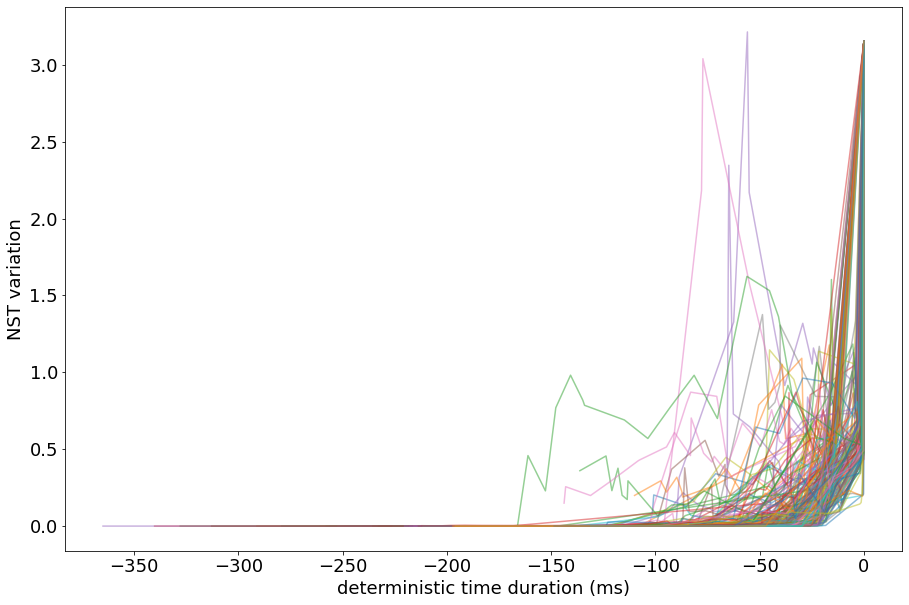

In [112]:
plt.figure(figsize = (15,10))
for i in range(202):
    pstims = preceding_stims[i,:]
    rnsts_vars = np.flip(np.nanvar(rNSTs[i,:,:], axis = 1))
    plt.plot(pstims,rnsts_vars, alpha=0.5)
plt.xlabel('deterministic time duration (ms)')
plt.ylabel('NST variation')

# error occurs because there are is a single walk where the last 3 have no spikes at all
    # this was discovered lower in this notebook

/tmp/ipykernel_31654/1658008738.py:4: RuntimeWarning: Degrees of freedom <= 0 for slice.
  rnsts_vars = np.flip(np.nanvar(rNSTs[i,:,:], axis = 1))


Text(0, 0.5, 'NST variation')

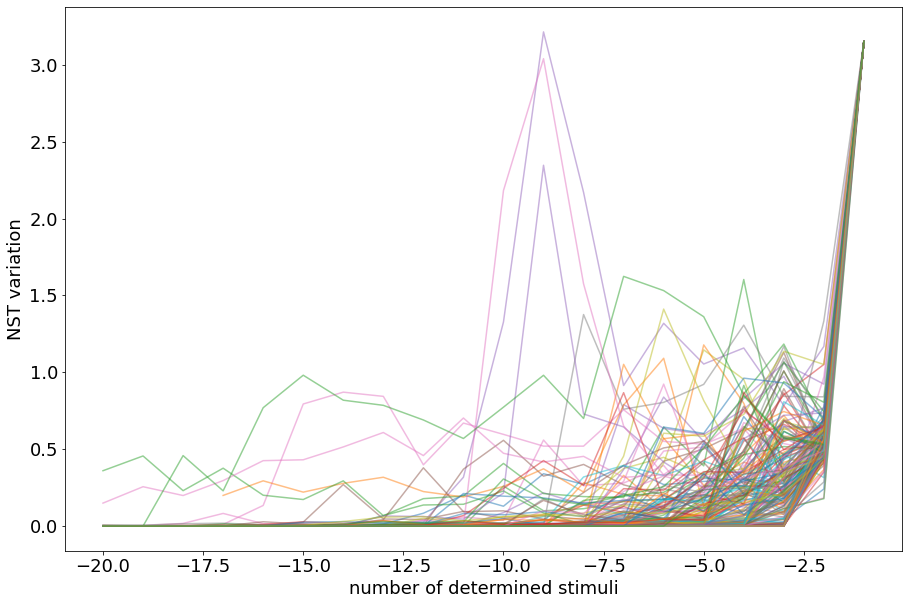

In [113]:
plt.figure(figsize = (15,10))
for i in range(len(pivots)):
    pstims = preceding_stims[i,:]
    rnsts_vars = np.flip(np.nanvar(rNSTs[i,:,:], axis = 1))
    plt.plot(range(-20,0),rnsts_vars, alpha=0.5)
plt.xlabel('number of determined stimuli')
plt.ylabel('NST variation')

## Some basic analyses

In [154]:
# time_determined x variance scatter plot
time_determined = []
number_determined = []
variances = []
stdevs = []
spiking_freq = []
_is = []
_js = []

for i in range(preceding_stims.shape[0]): # for each experiment
    current_stims = preceding_stims[i]
    for j in range(len(current_stims)): # for each walking subset of preceding_stims
        current_walking_stims = current_stims[-j-1:]
        
        current_rNSTs = rNSTs[i,j,:]
        # remove nans
        current_rNSTs = current_rNSTs[~np.isnan(current_rNSTs)]
        
        # time determined
        time_determined.append(current_walking_stims[0])
        # number determined
        number_determined.append(len(current_walking_stims))
        # next spike time variation
        variances.append(np.var(current_rNSTs))
        # next spike time variation
        stdevs.append(np.std(current_rNSTs))
        # frequency to spike
        spiking_freq.append(np.count_nonzero(~np.isnan(rNSTs[i,j,:])))
        
        _is.append(i)
        _js.append(j)

/home/ec753/venvs/jupyter_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ec753/venvs/jupyter_env/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ec753/venvs/jupyter_env/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ec753/venvs/jupyter_env/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [137]:
df = pd.DataFrame([
    time_determined,
    number_determined,
    variances,
    stdevs,
    spiking_freq,
    _is,
    _js,
])
df = df.transpose()
df.columns = [
    'time_determined',
    'number_determined',
    'variances',
    'stdevs',
    'spiking_freq',
    'i',
    'j'
]
df

,time_determined,number_determined,variances,stdevs,spiking_freq,i,j
0,0.000,1.0,3.151006,1.775107,291.0,0.0,0.0
1,-12.925,2.0,0.776365,0.881116,398.0,0.0,1.0
2,-15.600,3.0,0.276819,0.526136,463.0,0.0,2.0
3,-18.425,4.0,0.307877,0.554867,614.0,0.0,3.0
4,-18.800,5.0,0.290353,0.538844,978.0,0.0,4.0
...,...,...,...,...,...,...,...
4055,-179.800,16.0,0.000000,0.000000,1000.0,202.0,15.0
4056,-189.900,17.0,0.000000,0.000000,1000.0,202.0,16.0
4057,-193.125,18.0,0.000000,0.000000,1000.0,202.0,17.0
4058,-198.125,19.0,0.000000,0.000000,1000.0,202.0,18.0


## Discovery of above warning
Conclusion: a single experiment reaches a point after 18 preceding stimuli that no spikes can occur.

There is only one of these, but it could be interesting to investigate.

In [147]:
print(np.sum(np.isnan(df)))

print('\nindices of nan')
print(np.argwhere(np.isnan(np.array(df))))

time_determined      0
number_determined    0
variances            3
stdevs               3
spiking_freq         0
i                    0
j                    0
dtype: int64

indices of nan
[[1437    2]
 [1437    3]
 [1438    2]
 [1438    3]
 [1439    2]
 [1439    3]]


In [141]:
df.iloc[1438]

time_determined     -148.325
number_determined     19.000
variances                NaN
stdevs                   NaN
spiking_freq           0.000
i                     71.000
j                     18.000
Name: 1438, dtype: float64

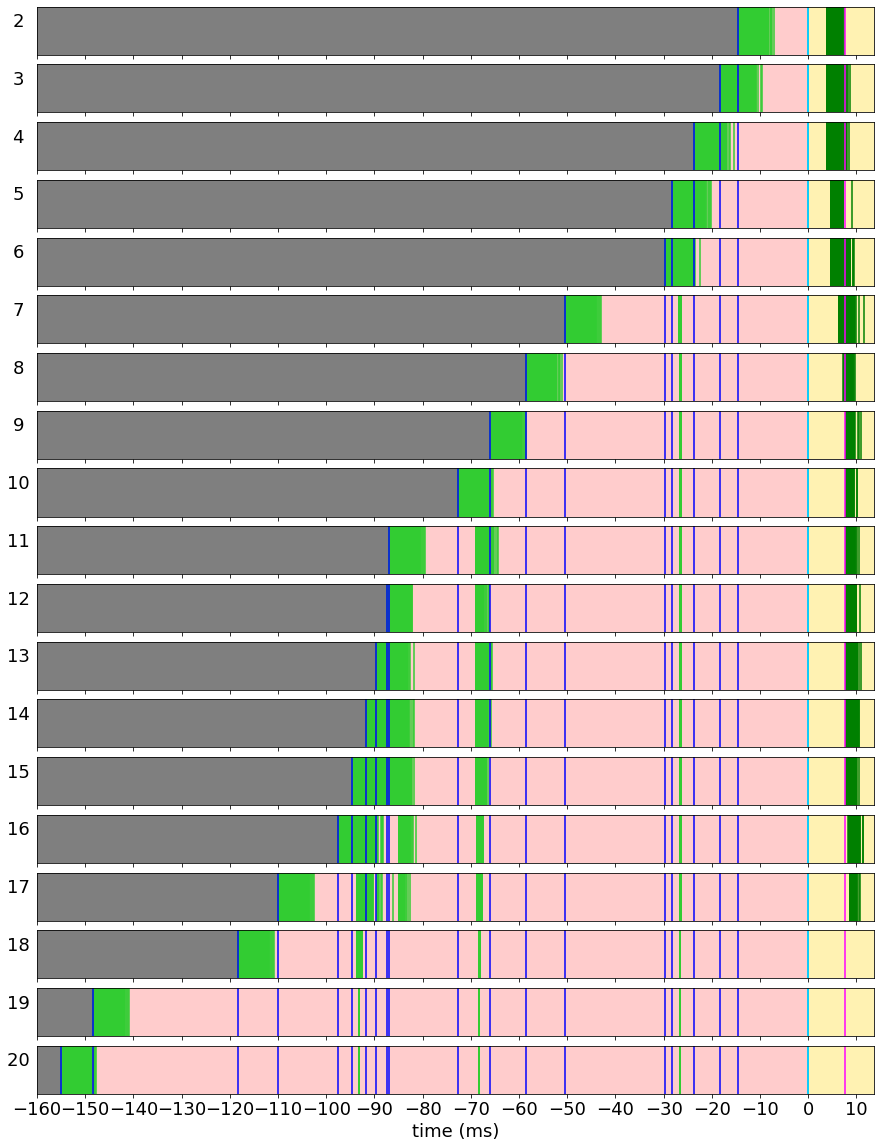

In [161]:
ind = 71
view_preceding_stims_walk(preceding_stims[ind,:], rNSTs[ind,:,:], rPSTs[ind], list(pivots.values())[ind])

/tmp/ipykernel_31654/250452768.py:32: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  axes[i_ax].set_ylim(0, max(patches.datavalues) * 1.1)


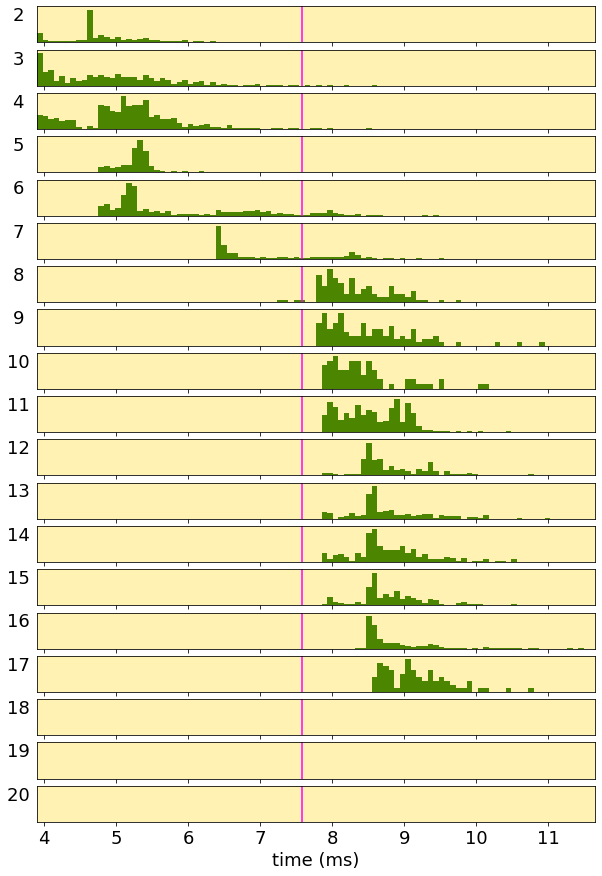

<BarContainer object of 100 artists>

In [162]:
view_NST_hists(preceding_stims[ind,:], rNSTs[ind,:,:], list(pivots.values())[ind])

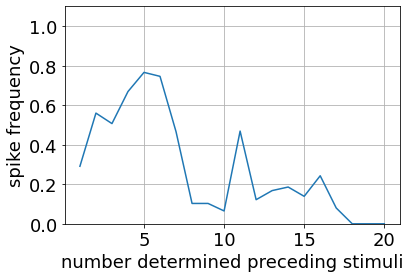

In [150]:
spike_freq = np.isnan(rNSTs[ind,:,:]).sum(axis=1)
spike_freq = np.isnan(rNSTs[ind,:,:]).sum(axis=1)/1000
spike_freq = [1-x for x in spike_freq]
plt.plot(range(1,21), spike_freq)
plt.ylim(0,1.1)
plt.grid()
plt.ylabel('spike frequency')
plt.xlabel('number determined preceding stimuli')
plt.show()

## More basic analyses

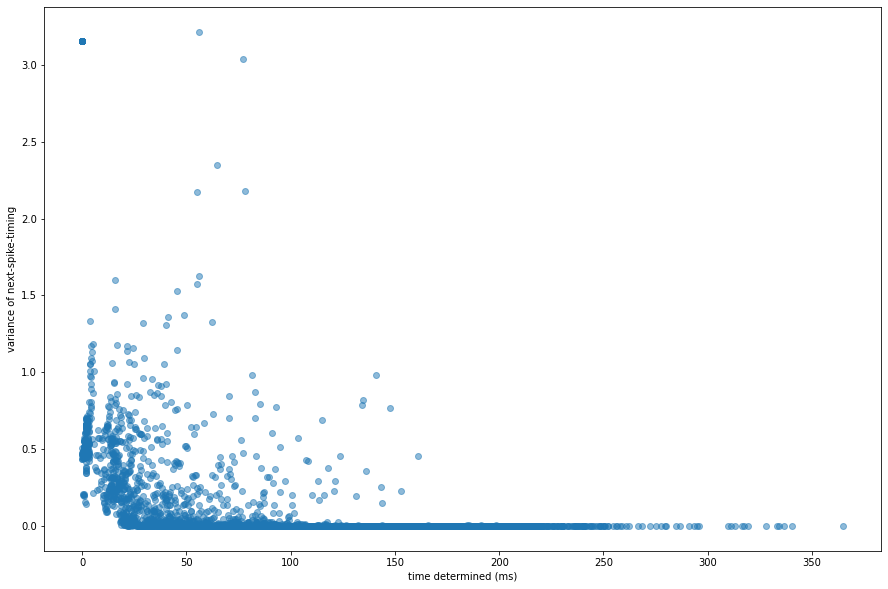

In [93]:
plt.figure(figsize = (15,10))
plt.scatter([td * -1 for td in time_determined], variances, alpha = 0.5)
plt.ylabel('variance of next-spike-timing')
plt.xlabel('time determined (ms)')
plt.show()

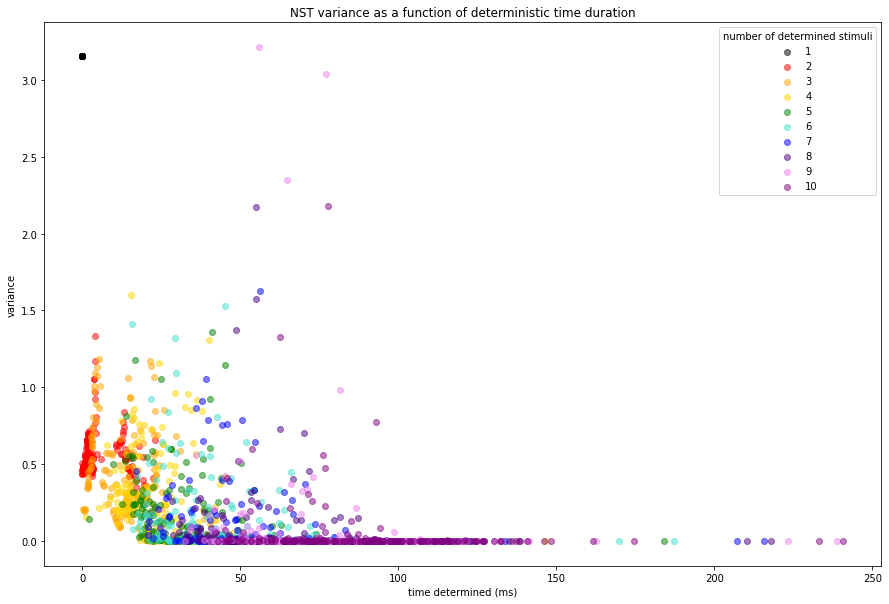

In [94]:
number_determined_np = np.array(number_determined)
time_determined_np = np.array([td * -1 for td in time_determined])
variances_np = np.array(variances)
spiking_freq_np = np.array(spiking_freq)

## Delta with addition of new stimuli

In [30]:
# delta between stimuli to increase in variance


number_determined_np = np.array(number_determined)
time_determined_np = np.array([td * -1 for td in time_determined])
variances_np = np.array(variances)
spiking_freq_np = np.array(spiking_freq)


In [47]:
# number_determined, time_i, time_i-1, variance_i, variance_i-1
deltas = []

for i, nd in enumerate(number_determined):
    if nd != 1:        
        deltas.append([
            nd,
            time_determined_np[i],
            time_determined_np[i-1],
            variances_np[i],
            variances_np[i-1]
        ])
deltas = pd.DataFrame(deltas, columns=[
    'number_determined',
    'time_i',
    'time_i-1',
    'variance_i',
    'variance_i-1',
])
deltas.head(n=21)

,number_determined,time_i,time_i-1,variance_i,variance_i-1
0,2,12.925,-0.000,7.221913e-01,3.271044e+00
1,3,15.600,12.925,2.183574e-01,7.221913e-01
2,4,18.425,15.600,3.180660e-01,2.183574e-01
3,5,18.800,18.425,2.720904e-01,3.180660e-01
4,6,29.450,18.800,2.485427e-01,2.720904e-01
5,7,46.425,29.450,3.948258e-01,2.485427e-01
6,8,53.350,46.425,2.731332e-01,3.948258e-01
7,9,71.075,53.350,3.397337e-01,2.731332e-01
8,10,85.025,71.075,1.380561e-01,3.397337e-01
9,11,100.800,85.025,1.862380e-01,1.380561e-01


In [70]:
# load stim times
with open('./data/stim_times.txt', 'r') as f:
    stim_times = [float(line.strip()) for line in f.readlines()]
stim_times_deltas = []
for i, st in enumerate(stim_times):
    if i > 0:
        stim_times_deltas.append(stim_times[i] - stim_times[i-1])

In [71]:
from scipy.optimize import curve_fit
from scipy import stats

def exp_fit(x,a,b):
    y = a*np.exp(-b*x)
    return y

In [72]:
hist, bins = np.histogram(stim_times_deltas, bins='auto')
x = np.arange(0, len(hist), 1)
x_fit = x + x[1]/2
fit_ = curve_fit(exp_fit, x_fit, hist)
fit_eq = fit_[0][0]*np.exp(-fit_[0][1]*x_fit)

/tmp/ipykernel_31654/117480729.py:5: RuntimeWarning: overflow encountered in exp
  y = a*np.exp(-b*x)


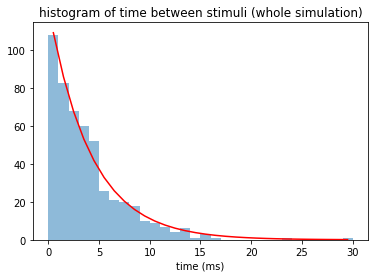

In [73]:
plt.bar(x,hist, alpha = 0.5, align = 'edge', width = 1)
plt.plot(x_fit,fit_eq, color = 'red')
plt.title('histogram of time between stimuli (whole simulation)')
plt.xlabel('time (ms)')
plt.show()

/tmp/ipykernel_31654/117480729.py:5: RuntimeWarning: overflow encountered in exp
  y = a*np.exp(-b*x)
/tmp/ipykernel_31654/117480729.py:5: RuntimeWarning: overflow encountered in exp
  y = a*np.exp(-b*x)
/tmp/ipykernel_31654/117480729.py:5: RuntimeWarning: overflow encountered in exp
  y = a*np.exp(-b*x)
/tmp/ipykernel_31654/117480729.py:5: RuntimeWarning: overflow encountered in exp
  y = a*np.exp(-b*x)
/tmp/ipykernel_31654/117480729.py:5: RuntimeWarning: overflow encountered in exp
  y = a*np.exp(-b*x)
/tmp/ipykernel_31654/117480729.py:5: RuntimeWarning: overflow encountered in exp
  y = a*np.exp(-b*x)
/tmp/ipykernel_31654/117480729.py:5: RuntimeWarning: overflow encountered in exp
  y = a*np.exp(-b*x)
/tmp/ipykernel_31654/117480729.py:5: RuntimeWarning: overflow encountered in exp
  y = a*np.exp(-b*x)
/tmp/ipykernel_31654/117480729.py:5: RuntimeWarning: overflow encountered in exp
  y = a*np.exp(-b*x)
/tmp/ipykernel_31654/117480729.py:5: RuntimeWarning: overflow encountered in multi

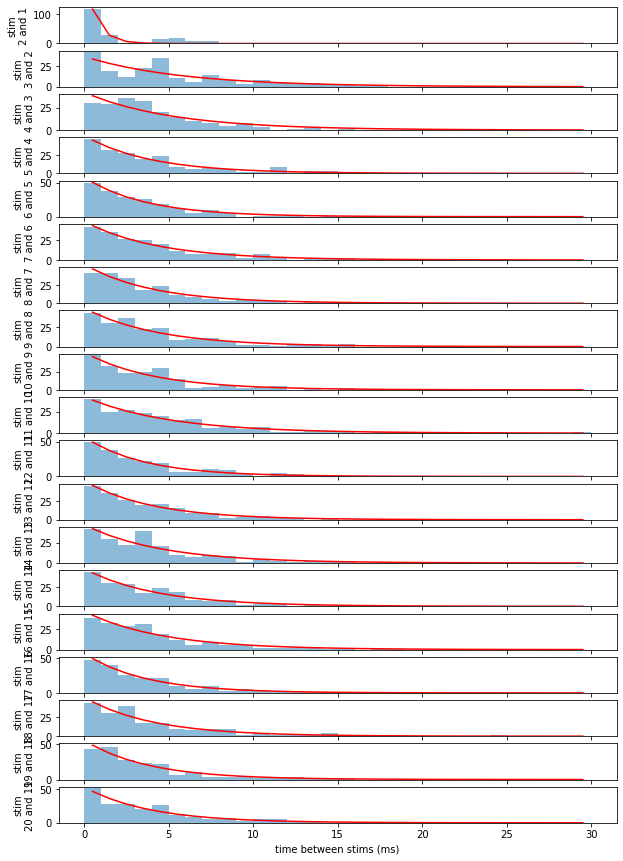

In [74]:
fig, axes = plt.subplots(19,1, figsize = (10,15))

kstests = []

for i in range(2,21):
    deltas_slice = deltas[deltas['number_determined'] == i]
    deltas_current = deltas_slice['time_i'] - deltas_slice['time_i-1']
    
    _hist = np.histogram(deltas_current, bins=bins)[0]
    x = np.arange(0, len(_hist), 1)
    x_fit = x + x[1]/2
    fit_ = curve_fit(exp_fit, x_fit, _hist)
    fit_eq = fit_[0][0]*np.exp(-fit_[0][1]*x_fit)
    
    axes[i-2].bar(x, _hist, alpha = 0.5, align = 'edge', width = 1)
    axes[i-2].plot(x_fit, fit_eq, color = 'red')
    axes[i-2].set_ylabel('stim\n' + str(i) + ' and ' + str(i-1))
    
    # KS test
    kstests.append(stats.ks_2samp(deltas_current, stim_times_deltas))
    
axes[i-2].set_xlabel('time between stims (ms)')
plt.show()

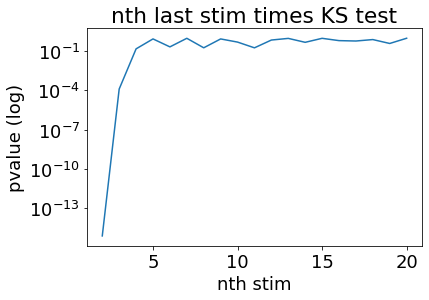

In [156]:
plt.plot(range(2,21), [ks[1] for ks in kstests], )
plt.yscale('log')
plt.title('nth last stim times KS test')
plt.ylabel('pvalue (log)')
plt.xlabel('nth stim')

plt.show()